In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import feature_engine
from sklearn.model_selection import train_test_split

#### Variáveis

BAD - 1 = "default”; 0 = não "default" - Target  
CLAGE - O tempo que tem a mais antiga conta (em meses)  
CLNO - Número de linhas de crédito  
DEBTINC - Relação entre dívida/receita  
DELINQ - Número de linhas de crédito inadimplentes  
DEROG - Número de relatórios depreciativos  
JOB - Categoria Ocupacional  
LOAN - Montante "em dinheiro" do empréstimo solicitado  
MORTDUE - Montante "em dinheiro" devido nas hipotecas ativas  
NINQ - Número de consulta de crédito recentes  
REASON - DebtCon= consolidação de dívida; HomeImp = melhoramento
da casa  
VALUE - Valor da propriedade atual  
YOJ - Anos no trabalho atual

In [258]:
cliente_df = pd.read_csv('./Dados/yochi_base.csv', sep=';')

### **Existem candidatos a Dummie?**

In [259]:
cliente_df.JOB.value_counts(dropna=False)

Other      2388
ProfExe    1276
Office      948
Mgr         767
NaN         279
Self        193
Sales       109
Name: JOB, dtype: int64

In [260]:
cliente_df.REASON.value_counts(dropna=False)

DebtCon    3928
HomeImp    1780
NaN         252
Name: REASON, dtype: int64

**R: Como as variáveis Job e Reason possuem mais de duas categorias e menos de 6, resolvi considerar que as duas serão transformadas em dummie.**

In [261]:
lst_dummies = ['JOB','REASON']

### **Existem Valores Inválidos?**

In [262]:
cliente_df.tail()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5955,0,88900,57264,90185,DebtCon,Other,16,0.0,0.0,"221,8087175",0.0,16.0,"36,11234652"
5956,0,89000,54576,92937,DebtCon,Other,16,0.0,0.0,"208,6920698",0.0,15.0,"35,85997068"
5957,0,89200,54045,92924,DebtCon,Other,15,0.0,0.0,"212,2796967",0.0,15.0,"35,55659049"
5958,0,89800,50370,91861,DebtCon,Other,14,0.0,0.0,"213,892709",0.0,16.0,"34,34088237"
5959,0,89900,48811,88934,DebtCon,Other,15,0.0,0.0,"219,6010022",0.0,16.0,"34,57151913"


**R: Ao análisar os dados numéricos percebi que os valores das variáveis CLAGE, YOJ, DEBTINC, LOAN, MORTDUE e VALUE estão configurados com "virgula", o que para o python, não considera como numérico. Dessa forma, será necessário alterar trocando o "." por ",".**

In [263]:
def transform(df, lst_categoricos, lst_zeros):
    # Transformar os valores de CLAGE e YOJ e DEBTINC para valores com ponto no lugar de virgula
    df.CLAGE = df.CLAGE.str.replace(",",".").astype(float)
    df.YOJ = df.YOJ.str.replace(",",".").astype(float)
    df.DEBTINC = df.DEBTINC.str.replace(",",".").astype(float)
    # Transforma os campos Loan, Mortdue e Value de Object para float
    df.LOAN = df.LOAN.astype(str).str.replace(",",".").astype(float)
    df.MORTDUE = df.MORTDUE.astype(str).str.replace(",",".").astype(float)
    df.VALUE = df.VALUE.astype(str).str.replace(",",".").astype(float)

    # Transforma os nomes REASON e JOB incluindo o identificador _cat para identificar que são categóricos
    for column in lst_categoricos:
        df[column +'_CAT'] = df[column].astype('object')

    df = df.drop(columns = lst_categoricos)

    # Preenche com zero os valores que podem ser considerados com zero
    for column in lst_zeros:
        df[column] = df[column].fillna(0)

    return df

### Existem valores ausentes?

In [264]:
cliente_df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

MORTDUE: Poderá ser preenchido com zero, uma vez que se não existe divida de hipoteca ativa, poderá ser zero mesmo
VALUE: Poderá ser preenchido com zero, uma vez que o cliente pode não ter nenhuma propriedade atual
YOJ:Poderá ser preenchido com zero, uma vez que o cliente pode não ter completado nenhum ano no trabalho atual
DEROG: Poderá ser preenchido com zero, uma vez que podem não existir relatórios depreciativos
DELINQ:Poderá ser preenchido com zero, uma vez que podem não existir linhas de créditos inadimplentes
CLAGE: Poderá ser preenchido com zero, uma vez que poderá não existir nenhuma conta antiga
NINQ: Poderá ser preenchido com zero, uma vez que o cliente pode não ter feito consultas de crédito recentes
CLNO: Poderá ser preenchido com zero, uma vez que o cliente pode não ter nenhuma linha de crédito
DEBTINC: Poderá ser preenchido com zero, uma vez que o cliente pode não ter relação entre divida/receita

In [265]:
lst_zero = ['MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']

In [266]:
# Aplica as transformações
cliente_df = cliente_df.pipe(transform, lst_categoricos=lst_dummies, lst_zeros= lst_zero)

In [267]:
cliente_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BAD         5960 non-null   int64  
 1   LOAN        5960 non-null   float64
 2   MORTDUE     5960 non-null   float64
 3   VALUE       5960 non-null   float64
 4   YOJ         5960 non-null   float64
 5   DEROG       5960 non-null   float64
 6   DELINQ      5960 non-null   float64
 7   CLAGE       5960 non-null   float64
 8   NINQ        5960 non-null   float64
 9   CLNO        5960 non-null   float64
 10  DEBTINC     5960 non-null   float64
 11  JOB_CAT     5681 non-null   object 
 12  REASON_CAT  5708 non-null   object 
dtypes: float64(10), int64(1), object(2)
memory usage: 605.4+ KB


### **A target está desbalanceada?**

In [268]:
cliente_df.BAD.value_counts(normalize=True)

0    0.800503
1    0.199497
Name: BAD, dtype: float64

**R: Consideramos que 20% ainda é um bom balanceamento**

### Gráficos & Analises

#### Loan

In [269]:
cliente_df['LOAN'].describe()

count     5960.000000
mean     18607.969799
std      11207.480417
min       1100.000000
25%      11100.000000
50%      16300.000000
75%      23300.000000
max      89900.000000
Name: LOAN, dtype: float64

<Figure size 648x576 with 0 Axes>

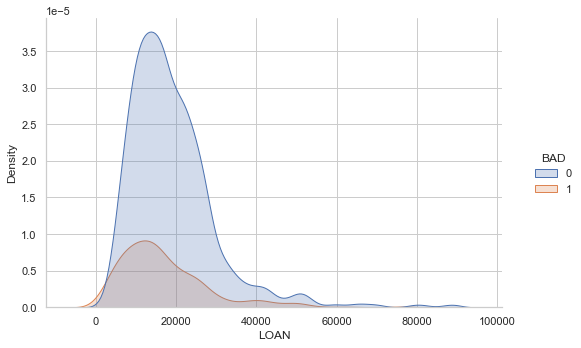

In [270]:
plt.figure(figsize=(9, 8))
#sns.distplot(x=cliente_df['LOAN'], color='g', bins=100, hist_kws={'alpha': 0.4});
sns.displot(data=cliente_df, x='LOAN', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

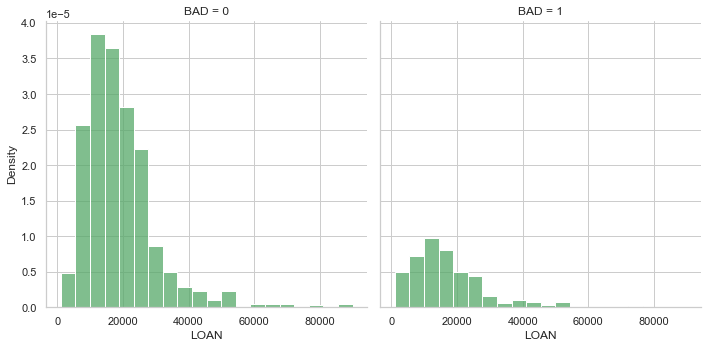

In [271]:
sns.displot(cliente_df, x="LOAN", col="BAD",multiple="dodge",color='g',stat="density", bins=20)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

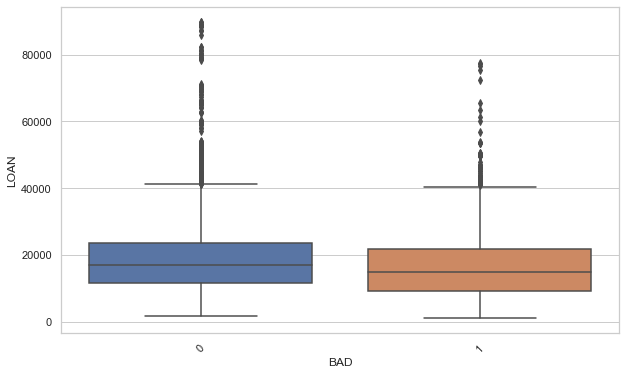

In [272]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='LOAN', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### MORTDUE

In [273]:
cliente_df['MORTDUE'].describe()

count      5960.000000
mean      67350.061611
std       47291.714068
min           0.000000
25%       38996.500000
50%       61739.500000
75%       88200.250000
max      399550.000000
Name: MORTDUE, dtype: float64

<Figure size 648x576 with 0 Axes>

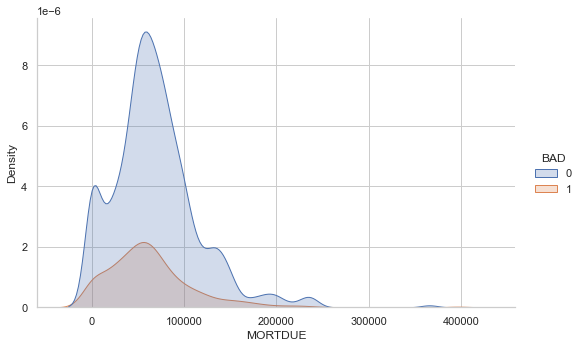

In [274]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='MORTDUE', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

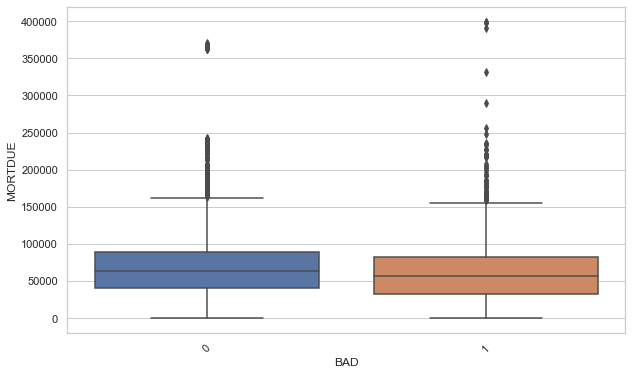

In [275]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='MORTDUE', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### VALUE

In [276]:
cliente_df['VALUE'].describe()

count      5960.000000
mean      99863.478698
std       58500.089789
min           0.000000
25%       65000.000000
50%       88310.500000
75%      119004.750000
max      855909.000000
Name: VALUE, dtype: float64

<Figure size 648x576 with 0 Axes>

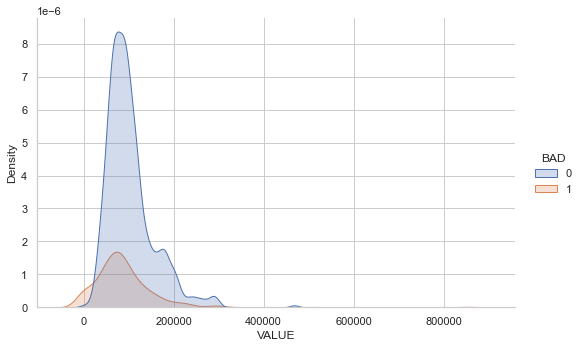

In [277]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='VALUE', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

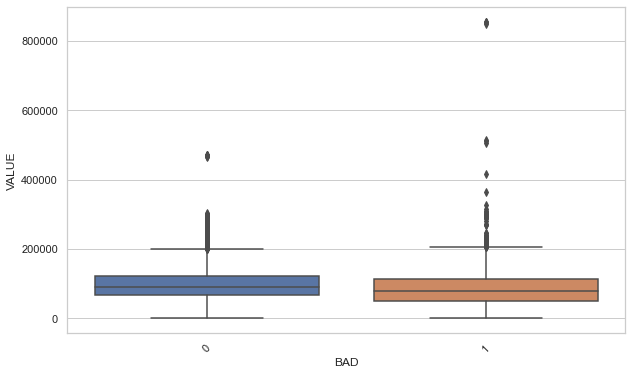

In [278]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='VALUE', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### YOJ - Anos no trabalho atual

In [279]:
cliente_df['YOJ'].describe()

count    5960.000000
mean        8.151300
std         7.661131
min         0.000000
25%         2.000000
50%         6.000000
75%        12.000000
max        41.000000
Name: YOJ, dtype: float64

<Figure size 648x576 with 0 Axes>

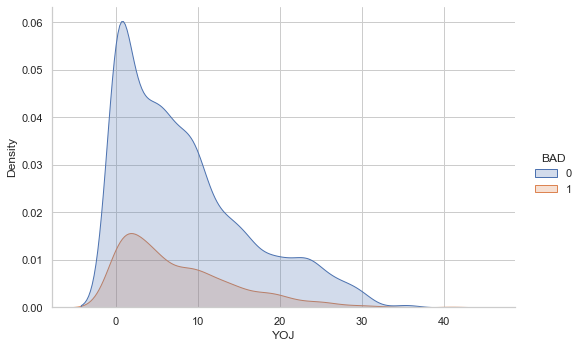

In [280]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='YOJ', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

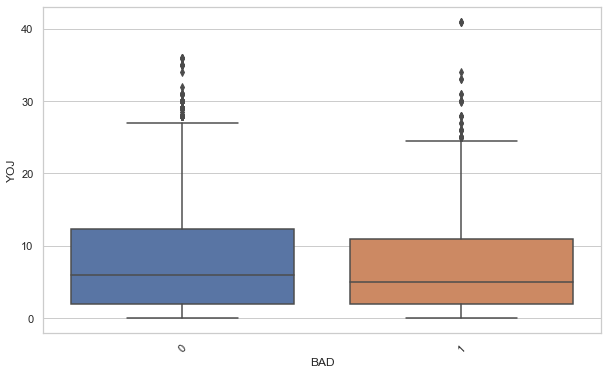

In [281]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='YOJ', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### DEROG - Número de relatórios depreciativos

In [282]:
cliente_df['DEROG'].describe()

count    5960.000000
mean        0.224329
std         0.798458
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: DEROG, dtype: float64

<Figure size 648x576 with 0 Axes>

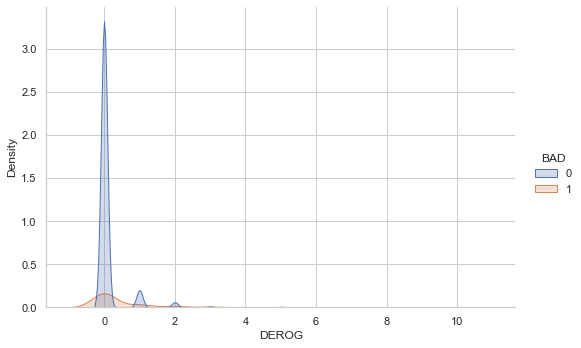

In [283]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='DEROG', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

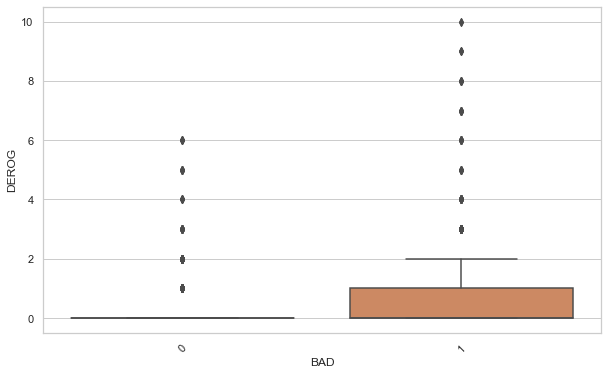

In [284]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='DEROG', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [285]:
cliente_df[cliente_df.DEROG>0].BAD.value_counts()

0    377
1    348
Name: BAD, dtype: int64

### DELINQ - Número de linhas de crédito inadimplentes

In [286]:
cliente_df['DELINQ'].describe()

count    5960.000000
mean        0.405705
std         1.079256
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.000000
Name: DELINQ, dtype: float64

In [287]:
cliente_df[cliente_df.DELINQ>0].BAD.value_counts()

0    667
1    534
Name: BAD, dtype: int64

<Figure size 648x576 with 0 Axes>

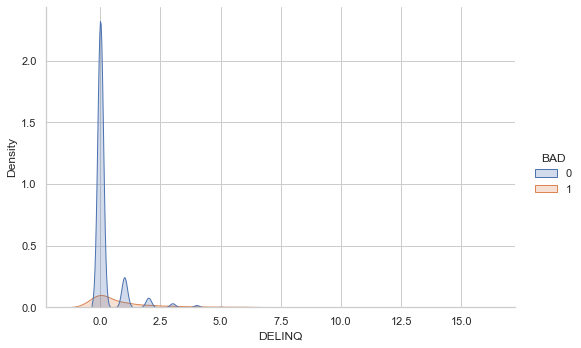

In [288]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='DELINQ', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

### CLAGE - O tempo que tem a mais antiga conta (em meses) 

In [289]:
cliente_df['CLAGE'].describe()

count    5960.000000
mean      170.476340
std        92.556818
min         0.000000
25%       107.670203
50%       166.675508
75%       227.143058
max      1168.233561
Name: CLAGE, dtype: float64

<Figure size 648x576 with 0 Axes>

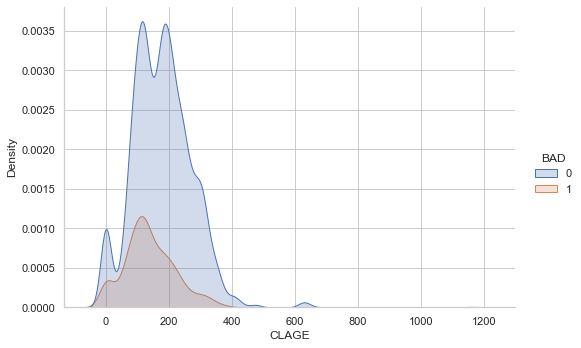

In [290]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='CLAGE', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

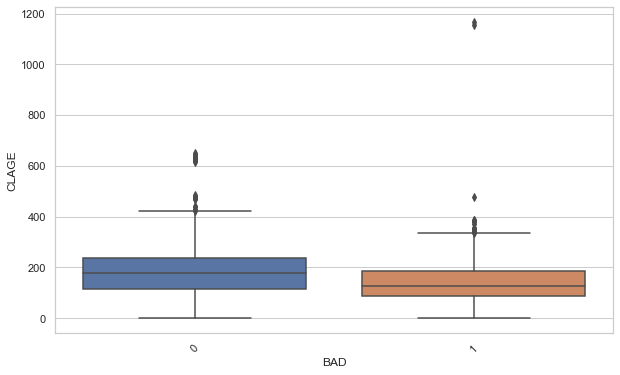

In [291]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='CLAGE', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### NINQ - Número de consulta de crédito recentes  

In [292]:
cliente_df['NINQ'].describe()

count    5960.000000
mean        1.084564
std         1.686017
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        17.000000
Name: NINQ, dtype: float64

In [293]:
cliente_df[cliente_df.NINQ>0].BAD.value_counts()

0    2201
1     718
Name: BAD, dtype: int64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

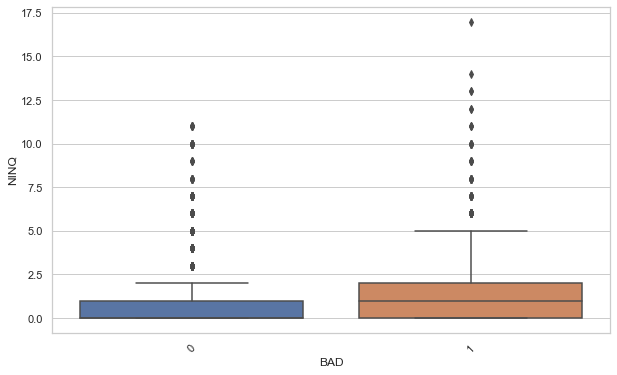

In [294]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='NINQ', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### CLNO - Número de linhas de crédito

In [295]:
cliente_df['CLNO'].describe()

count    5960.000000
mean       20.502852
std        10.734746
min         0.000000
25%        14.000000
50%        20.000000
75%        26.000000
max        71.000000
Name: CLNO, dtype: float64

<Figure size 648x576 with 0 Axes>

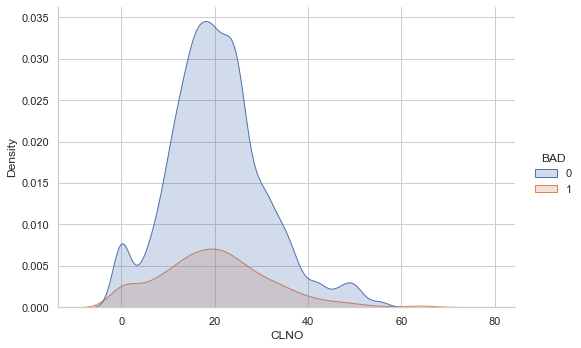

In [296]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='CLNO', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

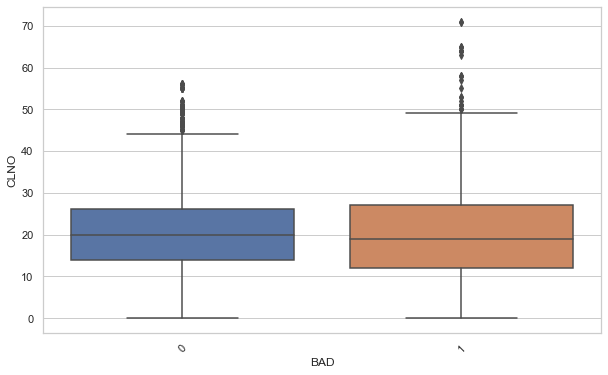

In [297]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='CLNO', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### DEBTINC - Relação entre dívida/receita

In [298]:
cliente_df['DEBTINC'].describe()

count    5960.000000
mean       26.598849
std        15.789188
min         0.000000
25%        20.340140
50%        31.923742
75%        37.949892
max       203.312149
Name: DEBTINC, dtype: float64

<Figure size 648x576 with 0 Axes>

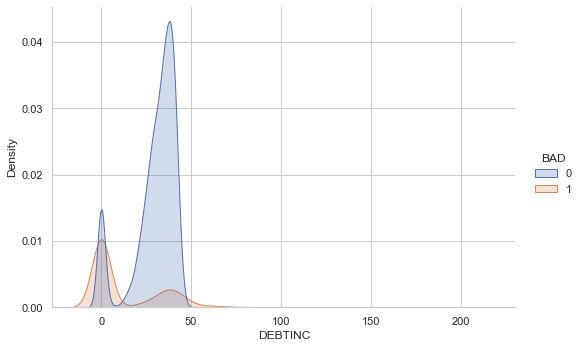

In [299]:
plt.figure(figsize=(9, 8))
sns.displot(data=cliente_df, x='DEBTINC', hue='BAD', color='g', kind='kde', fill=True, height=5, aspect=1.5)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

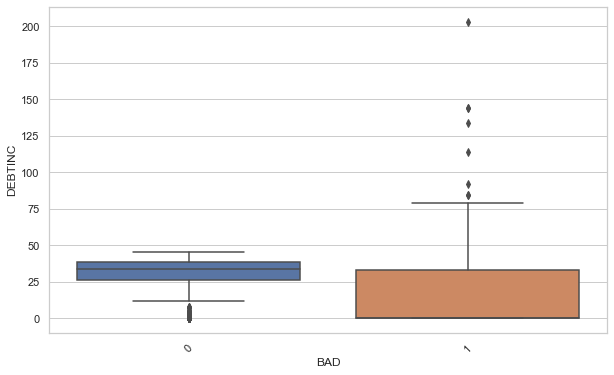

In [300]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x="BAD", y='DEBTINC', data=cliente_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### JOB_CAT - Categoria Ocupacional

In [301]:
cliente_df['JOB_CAT'].describe()

count      5681
unique        6
top       Other
freq       2388
Name: JOB_CAT, dtype: object

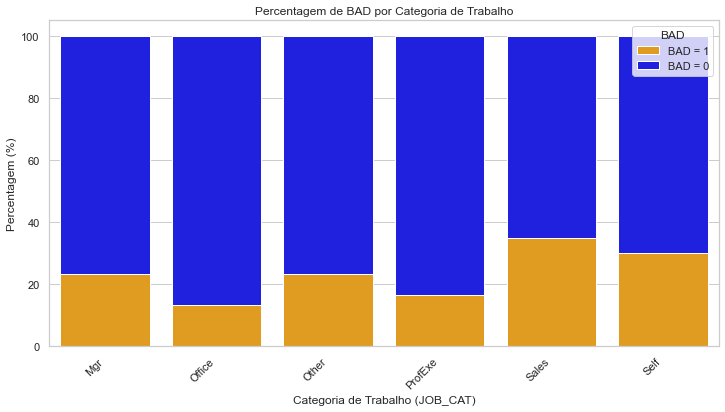

In [302]:
# Crie um DataFrame com a contagem de 'BAD' para cada categoria de trabalho
data = cliente_df.groupby(['JOB_CAT', 'BAD']).size().unstack().fillna(0)

# Calcule as percentagens dentro de cada categoria de trabalho
data_percent = data.div(data.sum(axis=1), axis=0) * 100

# Configure o estilo do Seaborn
sns.set(style="whitegrid")

# Crie o gráfico de barras lado a lado (clustered bar) percentualizado
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=data_percent.reset_index(), x='JOB_CAT', y=1, color='orange', label='BAD = 1')
ax = sns.barplot(data=data_percent.reset_index(), x='JOB_CAT', y=0, color='blue', label='BAD = 0', bottom=data_percent[1])

# Adicione rótulos e título
plt.xlabel('Categoria de Trabalho (JOB_CAT)')
plt.ylabel('Percentagem (%)')
plt.title('Percentagem de BAD por Categoria de Trabalho')

# Personalize a legenda
plt.legend(title='BAD', loc='upper right')

# Gire os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha="right")

plt.show()


### REASON_CAT - DebtCon= consolidação de dívida; HomeImp = melhoramento da casa

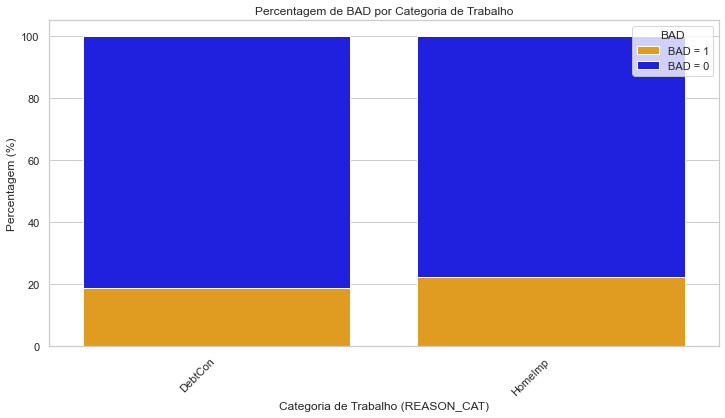

In [303]:
# Crie um DataFrame com a contagem de 'BAD' para cada categoria de trabalho
data = cliente_df.groupby(['REASON_CAT', 'BAD']).size().unstack().fillna(0)

# Calcule as percentagens dentro de cada categoria de trabalho
data_percent = data.div(data.sum(axis=1), axis=0) * 100

# Configure o estilo do Seaborn
sns.set(style="whitegrid")

# Crie o gráfico de barras lado a lado (clustered bar) percentualizado
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=data_percent.reset_index(), x='REASON_CAT', y=1, color='orange', label='BAD = 1')
ax = sns.barplot(data=data_percent.reset_index(), x='REASON_CAT', y=0, color='blue', label='BAD = 0', bottom=data_percent[1])

# Adicione rótulos e título
plt.xlabel('Categoria de Trabalho (REASON_CAT)')
plt.ylabel('Percentagem (%)')
plt.title('Percentagem de BAD por Categoria de Trabalho')

# Personalize a legenda
plt.legend(title='BAD', loc='upper right')

# Gire os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha="right")

plt.show()


### Divisão dos Dados

In [304]:
X = cliente_df.drop('BAD', axis = 1)
y = cliente_df['BAD']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0, stratify = y)

# --------------- contando -----------------
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
y_test.head()

0    0.800545
1    0.199455
Name: BAD, dtype: float64
0    0.800336
1    0.199664
Name: BAD, dtype: float64


4987    0
3190    0
301     0
5187    1
3240    0
Name: BAD, dtype: int64

### Preencher dados nulos (Categóricos)
Somente iremos tratar os nulos categóricos pois os valores numéricos foram tratados na primeira etapa

In [305]:
x_train.isnull().sum()

LOAN            0
MORTDUE         0
VALUE           0
YOJ             0
DEROG           0
DELINQ          0
CLAGE           0
NINQ            0
CLNO            0
DEBTINC         0
JOB_CAT       229
REASON_CAT    210
dtype: int64

In [306]:
from feature_engine.imputation import CategoricalImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline

In [307]:
ci = CategoricalImputer(imputation_method='missing', fill_value='nao_informado')

In [308]:
# Filtrar colunas que terminam com "_CAT"
filtered_columns = [col for col in x_train.columns if col.endswith("_CAT")]
ohe = ce.OneHotEncoder(cols=filtered_columns, handle_unknown='0', use_cat_names=True)

In [309]:
# Crie o pipeline
pipeline = Pipeline([
    ('imputer', ci),  # Imputação de valores ausentes
    ('onehot', ohe)  # Codificação one-hot (ou outra transformação)
])

# Ajuste e transforme os dados
X_transformed = pipeline.fit_transform(x_train)

In [310]:
X_transformed

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JOB_CAT_Mgr,JOB_CAT_Office,JOB_CAT_Self,JOB_CAT_ProfExe,JOB_CAT_nao_informado,JOB_CAT_Other,JOB_CAT_Sales,REASON_CAT_DebtCon,REASON_CAT_HomeImp,REASON_CAT_nao_informado
868,8800.0,108608.0,0.0,0.0,0.0,6.0,253.471759,4.0,23.0,0.000000,1,0,0,0,0,0,0,1,0,0
2155,13400.0,95084.0,117279.0,4.0,0.0,0.0,145.962344,0.0,21.0,39.244669,0,1,0,0,0,0,0,0,1,0
5798,48800.0,47476.0,105332.0,9.0,0.0,0.0,194.138918,3.0,36.0,40.653435,0,0,1,0,0,0,0,0,1,0
5904,63300.0,202000.0,281000.0,2.0,0.0,0.0,99.433333,2.0,21.0,0.000000,0,0,0,1,0,0,0,1,0,0
3564,18700.0,66003.0,82410.0,0.0,1.0,0.0,85.773808,1.0,23.0,51.517385,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5343,30200.0,124000.0,171366.0,13.0,0.0,0.0,176.500000,2.0,28.0,0.000000,1,0,0,0,0,0,0,1,0,0
2880,16000.0,82097.0,100225.0,0.0,0.0,0.0,129.374513,0.0,22.0,39.827217,0,0,0,0,0,1,0,1,0,0
1718,12000.0,87000.0,101200.0,13.0,0.0,2.0,151.133333,1.0,18.0,0.000000,0,0,0,0,0,0,1,1,0,0
46,3000.0,47000.0,82700.0,10.0,0.0,1.0,262.166667,5.0,26.0,0.000000,0,0,0,1,0,0,0,0,1,0


In [311]:
# Ajuste e transforme os dados
X_test_transformed = pipeline.fit_transform(x_test)

In [312]:
X_test_transformed

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JOB_CAT_Self,JOB_CAT_Other,JOB_CAT_Mgr,JOB_CAT_ProfExe,JOB_CAT_Office,JOB_CAT_nao_informado,JOB_CAT_Sales,REASON_CAT_HomeImp,REASON_CAT_DebtCon,REASON_CAT_nao_informado
4987,26400.0,240907.0,260638.0,7.0,1.0,0.0,255.415514,3.0,51.0,37.652919,1,0,0,0,0,0,0,1,0,0
3190,17100.0,43085.0,68758.0,7.0,0.0,1.0,103.683856,3.0,49.0,30.353549,0,1,0,0,0,0,0,0,1,0
301,5900.0,74187.0,78976.0,9.0,0.0,1.0,118.442491,0.0,24.0,40.110407,0,1,0,0,0,0,0,1,0,0
5187,27900.0,90694.0,121543.0,5.0,2.0,1.0,107.046251,8.0,15.0,0.838118,0,0,1,0,0,0,0,0,1,0
3240,17300.0,110614.0,137552.0,6.0,0.0,0.0,85.232501,0.0,13.0,31.344366,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,89200.0,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0,1,0,0,0,0,0,0,1,0
828,8600.0,75464.0,84263.0,21.0,0.0,0.0,352.658271,0.0,47.0,28.196715,0,1,0,0,0,0,0,1,0,0
847,8700.0,77377.0,97070.0,3.0,0.0,0.0,68.854877,2.0,24.0,38.217726,0,0,1,0,0,0,0,0,1,0
5953,88800.0,53307.0,94058.0,16.0,0.0,0.0,218.304978,0.0,15.0,34.242465,0,1,0,0,0,0,0,0,1,0


LOAN                        1.038686e-07
MORTDUE                     3.982356e-07
VALUE                      -1.081204e-07
YOJ                        -1.196235e-03
DEROG                       8.406823e-02
DELINQ                      9.397004e-02
CLAGE                      -7.356749e-04
NINQ                        2.134877e-02
CLNO                       -1.257825e-04
DEBTINC                    -7.948689e-03
JOB_CAT_Mgr                -7.565941e-03
JOB_CAT_Office             -4.587488e-02
JOB_CAT_Self                6.344071e-02
JOB_CAT_ProfExe            -2.673617e-02
JOB_CAT_nao_informado      -1.885944e-01
JOB_CAT_Other               1.891981e-02
JOB_CAT_Sales               1.864109e-01
REASON_CAT_DebtCon         -1.925116e-02
REASON_CAT_HomeImp          2.033872e-02
REASON_CAT_nao_informado   -1.087557e-03
dtype: float64


<AxesSubplot:>

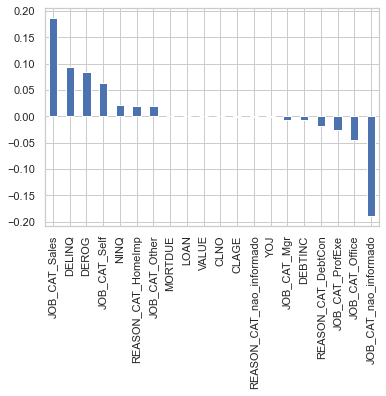

In [313]:
# #Testar seleção de variaveis - Regressão
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# Definir Modelo
model = LinearRegression()
model.fit(X_transformed,y_train)
# Importancia
importance = model.coef_
importance_reg = pd.Series(model.coef_, index=X_transformed.columns)
# Sumarrizar importancia
print(importance_reg)  
# Visualizar 
importance_reg.nlargest(20).plot(kind='bar')

In [314]:
#Seleção Univariate Por chi2 
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_transformed,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_transformed.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
#Poderiamos normalizar as variaveis continuas antes  
#Poderiamos fazer essa validação antes de criar o OnehotEncode

             Specs          Score
2            VALUE  832913.565574
0             LOAN  109273.612530
1          MORTDUE  105697.904883
9          DEBTINC    7415.901859
6            CLAGE    6929.383586
5           DELINQ    1674.908710
4            DEROG     973.842923
7             NINQ     354.282932
3              YOJ      54.124131
11  JOB_CAT_Office      24.553417


In [315]:
from feature_engine.selection import SelectByInformationValue

iv = SelectByInformationValue(bins=5,
    strategy="equal_frequency",
    threshold=0.02,)

X_transformed = iv.fit_transform(X_transformed, y_train)

[0.10138833 0.09929445 0.1267954  0.08942655 0.10937737 0.06591965
 0.10248063 0.30531763]


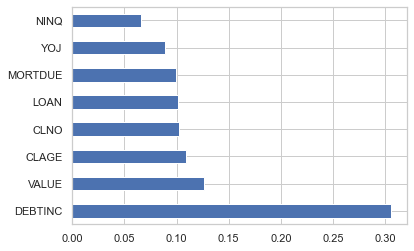

In [316]:
#Testar seleção de variaveis -  Arvore
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_transformed,y_train)
print(model.feature_importances_) #Utiliza uma arvore para definir a importancia das variaveis!
#Visualização da importnacia
importance_tree = pd.Series(model.feature_importances_, index=X_transformed.columns)
importance_tree.nlargest(14).plot(kind='barh')
plt.show() 
#Poderiamos normalizar as variaveis continuas antes  
#Poderiamos fazer essa validação antes de criar o OnehotEncode

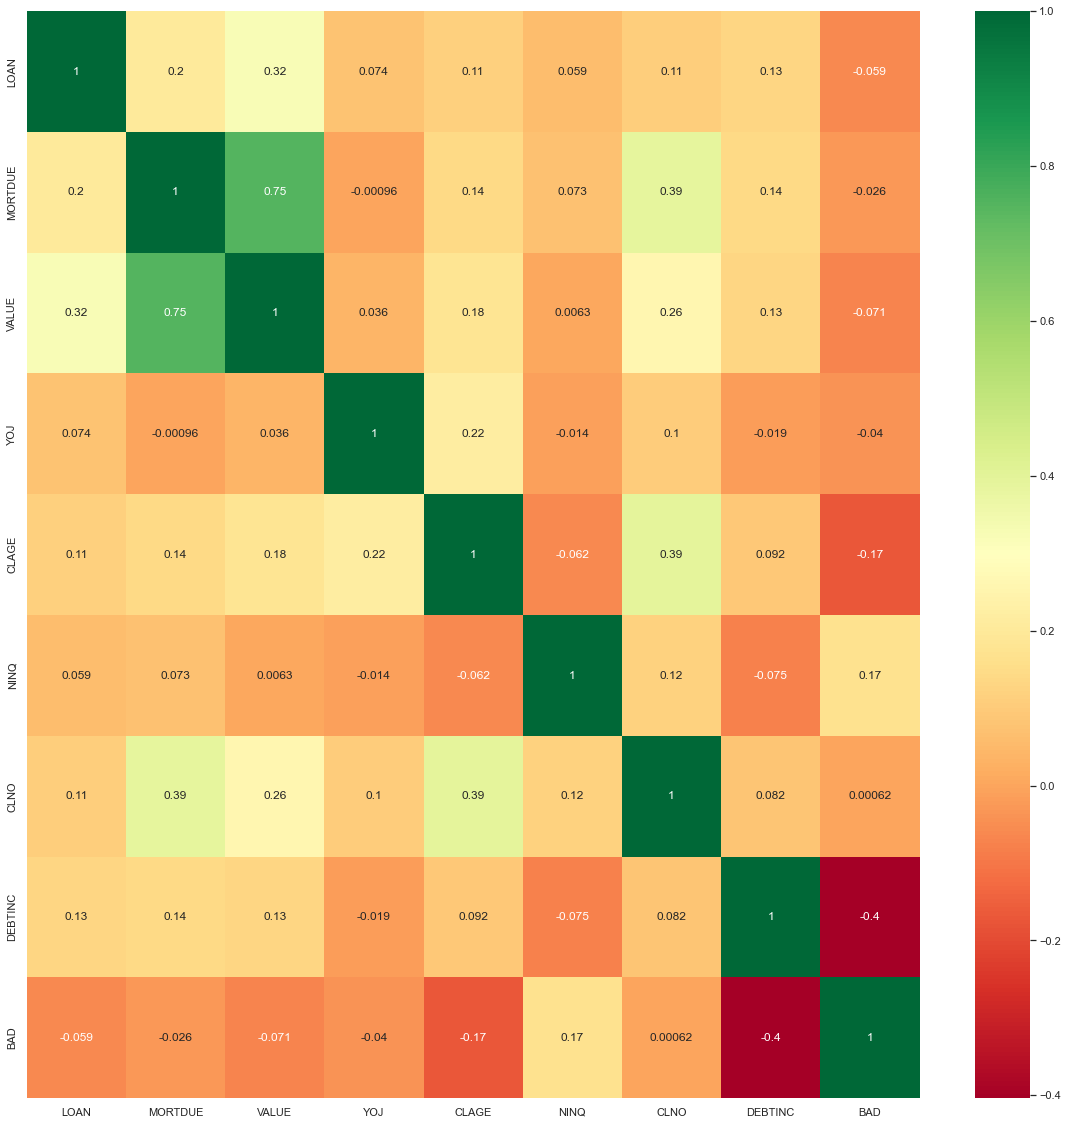

In [317]:
# Correlação !!
import pandas as pd
import numpy as np
import seaborn as sns

#get correlations of each features in dataset
corrmat = X_transformed.join(y_train).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X_transformed.join(y_train)[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [318]:
X_transformed.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'], dtype='object')

In [319]:
#Selecionar Variaveis
x_final = X_transformed[['LOAN',                     
                    'VALUE', 
                    'YOJ', 
                    'CLAGE', 
                    'NINQ', 
                    'CLNO', 
                    'DEBTINC',
    ]]

x_test_final =X_test_transformed[['LOAN',                     
                    'VALUE', 
                    'YOJ', 
                    'CLAGE', 
                    'NINQ', 
                    'CLNO', 
                    'DEBTINC',
    ]]

In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
model = LogisticRegression(solver='newton-cg',penalty ='l2',n_jobs =-1, random_state=0)

In [321]:
model.fit(x_final, y_train)

LogisticRegression(n_jobs=-1, random_state=0, solver='newton-cg')

In [322]:
#Numero de predições corretas
model.score(x_final, y_train)

0.8489932885906041

In [323]:
feature_name = x_final.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(model.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', model.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,3.187155e-01
1,LOAN,-4.928684e-08
2,VALUE,-1.006919e-06
3,YOJ,-5.118114e-03
4,CLAGE,-5.911406e-03
5,NINQ,1.659698e-01
6,CLNO,2.586863e-02
7,DEBTINC,-6.178990e-02


In [324]:
print(classification_report(y_train, model.predict(x_final)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3817
           1       0.69      0.44      0.54       951

    accuracy                           0.85      4768
   macro avg       0.78      0.69      0.72      4768
weighted avg       0.84      0.85      0.84      4768



In [325]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = y_test
lr_probs = model.predict_proba(x_test_final)
lr_probs = lr_probs[:, 1]

In [327]:
#Numero de predições corretas
model.score(x_test_final, y_test)

0.8565436241610739

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.800


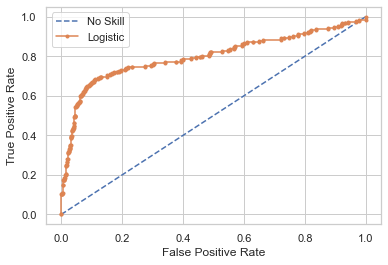

In [326]:
y_train_pred = model.predict(x_final)
y_test_pred = model.predict(x_test_final)

ns_probs = [0 for _ in range(len(y_test))]

lr_probs = model.predict_proba(x_test_final)
lr_probs = lr_probs[:, 1]                               
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

In [328]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [337]:
model.fit(x_final, y_train)

GradientBoostingClassifier(random_state=42)

In [331]:
#Numero de predições corretas
model.score(x_final, y_train)

0.9018456375838926

In [332]:
#Numero de predições corretas
model.score(x_test_final, y_test)

0.8859060402684564

In [335]:
# Faça previsões e avalie o modelo
y_pred = model.predict(x_test_final)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       954
           1       0.76      0.63      0.69       238

    accuracy                           0.89      1192
   macro avg       0.83      0.79      0.81      1192
weighted avg       0.88      0.89      0.88      1192

